###사전 설정

In [1]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install scipy pillow transformers

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xl2c0vzt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xl2c0vzt
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=0cfc724a2681a013d669d846ddc5368c5725e6fe0915dab244b50f12d80485de
  Stored in directory: /tmp/pip-ephem-wheel-cache-4wkax7dp/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Cloning into 'pytorch-fgvc-dataset'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects:

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from  tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import os
import scipy.io
import shutil
import clip
from PIL import Image
import pandas as pd

###데이터셋 다운로드

In [3]:
###class별 분류 stanford cars dataset
import kagglehub
path = kagglehub.dataset_download("cyizhuo/stanford-cars-by-classes-folder")


100%|██████████| 1.82G/1.82G [01:41<00:00, 19.3MB/s]

Extracting files...


In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")

100%|██████████| 1.82G/1.82G [01:23<00:00, 23.6MB/s]

Extracting files...


In [ ]:
# MAT 파일 경로
mat_file_path = "/content/dataset/cars_annos.mat"

# MAT 파일 읽기
data = scipy.io.loadmat(mat_file_path)

# 데이터 구조 확인
print(data.keys())  # 주요 키 확인

# 특정 키의 내용 확인
data['annotations']  # 'annotations' 키의 데이터 출력

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])


array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        ...,
        (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uint16), array([[196]], dtype=uint8), array([[1]], dtype=uint8)),
        (array(['car_ims/016184.jpg'], dtype='<U18'), array([[56]], dtype=uint8), array([

In [ ]:
# MAT 파일의 annotations 데이터
annotations = data['annotations']

# 데이터를 DataFrame으로 변환
data_list = []
for entry in annotations[0]:
    relative_im_path = entry[0][0]
    bbox_x1 = entry[1][0][0]
    bbox_y1 = entry[2][0][0]
    bbox_x2 = entry[3][0][0]
    bbox_y2 = entry[4][0][0]
    class_id = entry[5][0][0]
    is_test = entry[6][0][0]

    data_list.append({
        "image_path": relative_im_path,
        "bbox_x1": bbox_x1,
        "bbox_y1": bbox_y1,
        "bbox_x2": bbox_x2,
        "bbox_y2": bbox_y2,
        "class_id": class_id,
        "is_test": is_test
    })

df = pd.DataFrame(data_list)

df

In [14]:
# 디렉토리 경로
train_dir = "/content/dataset/test/AM General Hummer SUV 2000"
test_dir = "/content/dataset/train"

# Train 디렉토리 내용 확인
print("Train 폴더 파일:")
print(os.listdir(train_dir))

# Test 디렉토리 내용 확인
print("Test 폴더 파일:")
print(os.listdir(test_dir))

Train 폴더 파일:
['000072.jpg', '000047.jpg', '000080.jpg', '000081.jpg', '000089.jpg', '000068.jpg', '000049.jpg', '000051.jpg', '000082.jpg', '000070.jpg', '000079.jpg', '000066.jpg', '000060.jpg', '000076.jpg', '000054.jpg', '000053.jpg', '000083.jpg', '000069.jpg', '000085.jpg', '000065.jpg', '000055.jpg', '000071.jpg', '000056.jpg', '000075.jpg', '000061.jpg', '000073.jpg', '000088.jpg', '000064.jpg', '000087.jpg', '000078.jpg', '000067.jpg', '000074.jpg', '000084.jpg', '000046.jpg', '000058.jpg', '000063.jpg', '000077.jpg', '000057.jpg', '000062.jpg', '000052.jpg', '000048.jpg', '000059.jpg', '000050.jpg', '000086.jpg']
Test 폴더 파일:
['Hyundai Genesis Sedan 2012', 'Rolls-Royce Ghost Sedan 2012', 'Audi V8 Sedan 1994', 'Land Rover Range Rover SUV 2012', 'Ram C_V Cargo Van Minivan 2012', 'Chevrolet Silverado 1500 Extended Cab 2012', 'Mitsubishi Lancer Sedan 2012', 'Volvo C30 Hatchback 2012', 'Infiniti G Coupe IPL 2012', 'Rolls-Royce Phantom Drophead Coupe Convertible 2012', 'Buick Enclave

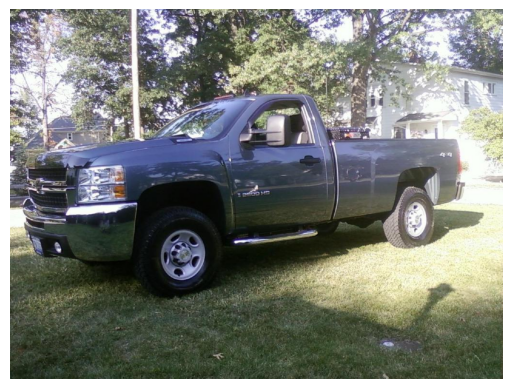

In [ ]:
# 이미지 파일 경로
image_path = "/content/dataset/cars_test/cars_test/00047.jpg"  # 실제 이미지 파일 경로 입력

# 이미지 열기 및 표시
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [20]:
# 원본 폴더 경로 (클래스별로 나뉜 이미지가 들어있는 폴더)
source_dir = "/content/dataset/test"

# 이미지를 하나로 모을 타겟 폴더 경로
target_dir = "/content/dataset/test"

# 타겟 폴더가 없으면 생성
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# 클래스별 폴더에서 이미지를 추출
for class_folder in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_folder)

    if os.path.isdir(class_path):  # 클래스 폴더인지 확인
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # 이미지 파일만 이동
            if os.path.isfile(image_path):
                # 중복 방지를 위해 파일명에 클래스 이름 추가
                new_name = f"{class_folder}_{image_file}"
                target_path = os.path.join(target_dir, new_name)

                # 파일 이동
                shutil.move(image_path, target_path)

print("이미지 이동 완료!")

이미지 이동 완료!


In [25]:
# 모든 파일이 모여 있는 폴더 경로
target_dir = "/content/dataset/test_flat"

# 파일명에서 클래스 이름 제거
for file_name in os.listdir(target_dir):
    file_path = os.path.join(target_dir, file_name)

    # 파일인지 확인
    if os.path.isfile(file_path):
        # 기존 파일명에서 클래스 이름 제거
        new_file_name = "_".join(file_name.split("_")[1:])  # 첫 번째 '_' 이전의 부분 제거
        new_file_path = os.path.join(target_dir, new_file_name)

        # 파일 이름 변경
        os.rename(file_path, new_file_path)

print("파일명 수정 완료!")

파일명 수정 완료!


###커스텀 preprocesses

In [57]:
def custom_preprocess(image, target_size=(224, 224), fill_color=(0, 0, 0)):
    """
    CLIP preprocess with aspect-ratio-preserving resizing and padding.

    Args:
        image (PIL.Image.Image): Input image.
        target_size (tuple): Target size (width, height).
        fill_color (tuple): Padding color (default: black).

    Returns:
        torch.Tensor: Processed tensor ready for CLIP.
    """
    # 1. Aspect-ratio-preserving resize with padding
    original_size = image.size
    target_width, target_height = target_size
    ratio = min(target_width / original_size[0], target_height / original_size[1])
    new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))
    resized_image = image.resize(new_size, Image.LANCZOS)

    # Create a new image with the target size and paste the resized image
    padded_image = Image.new("RGB", target_size, fill_color)
    top_left_x = (target_width - new_size[0]) // 2
    top_left_y = (target_height - new_size[1]) // 2
    padded_image.paste(resized_image, (top_left_x, top_left_y))

    # 2. Convert to Tensor and Normalize (same as CLIP preprocess)
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
    ])

    return transform(padded_image)

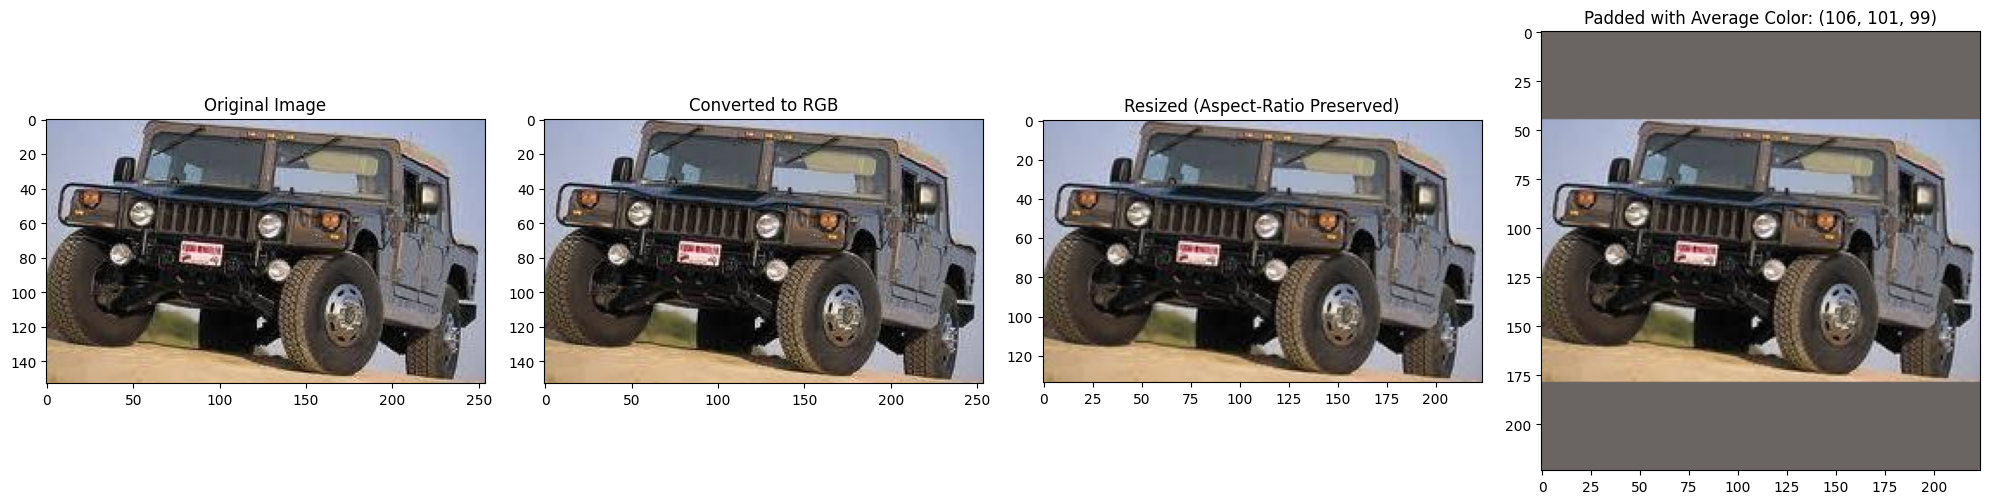

In [ ]:
# 테스트 이미지 로드
image_path = "/content/dataset/test_bboxes/000046.jpg"
image = Image.open(image_path)

# 변환 과정 시각화
visualize_custom_preprocess(image, target_size=(224, 224))

In [58]:
def custom_preprocess_with_avg_padding(image, target_size=(224, 224)):
    """
    CLIP preprocess with aspect-ratio-preserving resizing and average color padding.

    Args:
        image (PIL.Image.Image): Input image.
        target_size (tuple): Target size (width, height).

    Returns:
        torch.Tensor: Processed tensor ready for CLIP.
    """
    # Step 1: Ensure image is in RGB format
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Step 2: Calculate the average color of the image
    np_image = np.array(image)
    avg_color = np.mean(np_image, axis=(0, 1)).astype(int)  # 평균 색상 계산
    avg_color = tuple(avg_color[:3])  # RGB만 사용

    # Step 3: Aspect-ratio-preserving resize
    original_size = image.size
    target_width, target_height = target_size
    ratio = min(target_width / original_size[0], target_height / original_size[1])
    new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))
    resized_image = image.resize(new_size, Image.LANCZOS)

    # Step 4: Create padded image with average color
    padded_image = Image.new("RGB", target_size, avg_color)
    top_left_x = (target_width - new_size[0]) // 2
    top_left_y = (target_height - new_size[1]) // 2
    padded_image.paste(resized_image, (top_left_x, top_left_y))

    # Step 5: Convert to Tensor and Normalize (same as CLIP preprocess)
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
    ])

    return transform(padded_image)

In [ ]:
def visualize_custom_preprocess(image, target_size=(224, 224)):
    """
    이미지가 custom_preprocess_with_avg_padding을 거치는 과정을 시각적으로 확인합니다.

    Args:
        image (PIL.Image.Image): 입력 이미지.
        target_size (tuple): 목표 크기 (224, 224).
    """
    # 1. RGB 변환
    if image.mode != 'RGB':
        rgb_image = image.convert('RGB')
    else:
        rgb_image = image

    # 2. 평균 색상 계산
    np_image = np.array(rgb_image)
    avg_color = np.mean(np_image, axis=(0, 1)).astype(int)  # 평균 색상 계산
    avg_color = tuple(avg_color[:3])  # RGB만 사용

    # 3. 비율 유지 크기 조정
    original_size = rgb_image.size
    ratio = min(target_size[0] / original_size[0], target_size[1] / original_size[1])
    new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))
    resized_image = rgb_image.resize(new_size, Image.LANCZOS)

    # 4. 패딩 추가
    padded_image = Image.new("RGB", target_size, avg_color)
    top_left_x = (target_size[0] - new_size[0]) // 2
    top_left_y = (target_size[1] - new_size[1]) // 2
    padded_image.paste(resized_image, (top_left_x, top_left_y))

    # 5. Normalize 전 텐서 변환
    transform = T.ToTensor()
    tensor_image = transform(padded_image)

    # 시각화
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")

    axes[1].imshow(rgb_image)
    axes[1].set_title("Converted to RGB")

    axes[2].imshow(resized_image)
    axes[2].set_title(f"Resized (Aspect-Ratio Preserved)")

    axes[3].imshow(padded_image)
    axes[3].set_title(f"Padded with Average Color: {avg_color}")

    plt.tight_layout()
    plt.show()

Preprocess pipeline:
1: Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
2: CenterCrop(size=(224, 224))
3: <function _convert_image_to_rgb at 0x7d988203da20>
4: ToTensor()
5: Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))


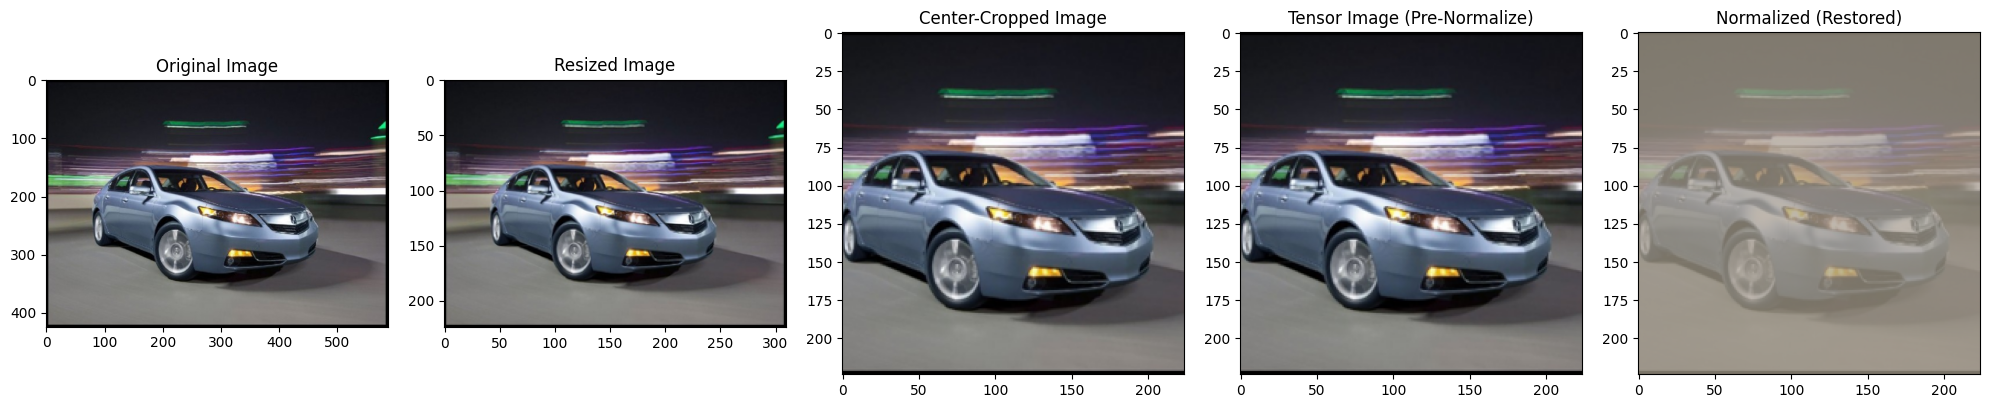

In [ ]:
import torchvision.transforms as T

# 테스트 이미지 불러오기
image_path = "/content/dataset/test_flat/000213.jpg"  # 테스트할 이미지 경로
image = Image.open(image_path)

# CLIP의 preprocess 단계 출력
print("Preprocess pipeline:")
for i, transform in enumerate(preprocess.transforms):
    print(f"{i+1}: {transform}")

# Preprocess 단계 분리
resize = preprocess.transforms[0]  # Resize
center_crop = preprocess.transforms[1]  # CenterCrop
convert_to_rgb = preprocess.transforms[2]  # RGB 변환
to_tensor = preprocess.transforms[3]  # ToTensor
normalize = preprocess.transforms[4]  # Normalize

# 단계별 변환 수행
resized_image = resize(image)
cropped_image = center_crop(resized_image)
rgb_image = convert_to_rgb(cropped_image)
tensor_image = to_tensor(rgb_image)
normalized_image = normalize(tensor_image)

# Normalize를 반전시키는 함수 (이미지 복원용)
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return tensor * std + mean

denormalized_image = denormalize(tensor_image, normalize.mean, normalize.std)

# 단계별 결과 시각화
fig, axes = plt.subplots(1, 5, figsize=(20, 8))

# 원본 이미지
axes[0].imshow(image)
axes[0].set_title("Original Image")

# Resize
axes[1].imshow(resized_image)
axes[1].set_title("Resized Image")

# CenterCrop
axes[2].imshow(cropped_image)
axes[2].set_title("Center-Cropped Image")

# Tensor Image (복원)
axes[3].imshow(tensor_image.permute(1, 2, 0))  # CHW -> HWC
axes[3].set_title("Tensor Image (Pre-Normalize)")

# Denormalized Image
axes[4].imshow(denormalized_image.permute(1, 2, 0).clip(0, 1))  # 값 범위를 [0, 1]로 제한
axes[4].set_title("Normalized (Restored)")

plt.tight_layout()
plt.show()

###clip 제로샷 평가

In [62]:
# Step 1: Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Step 2: Load the annotations from the .mat file
mat_file_path = "/content/dataset/cars_annos.mat"
data = scipy.io.loadmat(mat_file_path)

# Extract class names and annotations
class_names = [name[0] for name in data['class_names'][0]]  # Load class names
annotations = data['annotations'][0]  # Load annotations

# Step 3: Prepare prompts for zero-shot evaluation
prompts = [f"a photo of a {class_name}" for class_name in class_names]  # CLIP typical prompts
text_inputs = clip.tokenize(prompts).to(device)  # Tokenize prompts

# Encode the text prompts
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Step 4: Iterate through the test dataset in batches
test_dir = "/content/dataset/test_flat"  # Path to the flattened test dataset
batch_size = 64
image_paths = []
true_classes = []

# Collect all test images and their corresponding class IDs
for annotation in annotations:
    relative_image_path = annotation[0][0]  # Image path (e.g., "car_ims/000001.jpg")
    class_id = int(annotation[5][0][0]) - 1  # Class ID (1-based -> 0-based)
    image_path = os.path.join(test_dir, os.path.basename(relative_image_path))
    if os.path.exists(image_path):  # Only include valid paths
        image_paths.append(image_path)
        true_classes.append(class_id)

# Evaluate in batches
correct = 0
total = len(image_paths)

# Batch processing
for i in tqdm(range(0, total, batch_size)):
    batch_paths = image_paths[i:i + batch_size]
    batch_classes = true_classes[i:i + batch_size]

    # Load and preprocess images in the batch
    images = [preprocess(Image.open(p)).unsqueeze(0) for p in batch_paths]
    images = torch.cat(images).to(device)

    # Encode the images
    with torch.no_grad():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

    # Compute similarity with text prompts
    similarities = image_features @ text_features.T
    predicted_classes = similarities.argmax(dim=1).cpu().numpy()

    # Compare predictions with ground truth
    correct += sum(predicted_classes == batch_classes)

# Step 5: Compute accuracy
accuracy = correct / total * 100
print(f"Zero-shot CLIP Accuracy on the Test Dataset: {accuracy:.2f}%")

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]

Zero-shot CLIP Accuracy on the Test Dataset: 59.01%


###바운딩 박스에 맞춰 자른 이미지로 clip 제로샷

In [31]:
# .mat 파일 경로와 데이터 디렉토리 경로
mat_file_path = "/content/dataset/cars_annos.mat"
image_dir = "/content/dataset/test_flat"  # Flatten된 이미지 디렉토리
output_dir = "/content/dataset/test_bboxes"  # 바운딩 박스 처리된 이미지 저장 경로

# 출력 디렉토리 생성
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# .mat 파일 로드
data = scipy.io.loadmat(mat_file_path)
annotations = data['annotations'][0]  # Annotation 배열

# 바운딩 박스 추출 및 이미지 처리
for annotation in annotations:
    # 바운딩 박스 정보
    relative_path = annotation[0][0]  # 이미지 상대 경로
    x1 = int(annotation[1][0][0])  # 바운딩 박스 x1
    y1 = int(annotation[2][0][0])  # 바운딩 박스 y1
    x2 = int(annotation[3][0][0])  # 바운딩 박스 x2
    y2 = int(annotation[4][0][0])  # 바운딩 박스 y2

    # 원본 이미지 경로
    image_path = os.path.join(image_dir, os.path.basename(relative_path))
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue

    # 이미지 열기
    try:
        image = Image.open(image_path)
        # 바운딩 박스 영역 자르기
        cropped_image = image.crop((x1, y1, x2, y2))

        # 결과 저장
        output_path = os.path.join(output_dir, os.path.basename(relative_path))
        cropped_image.save(output_path)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

print(f"Processed images saved in {output_dir}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Image not found: /content/dataset/test_flat/006302.jpg
Image not found: /content/dataset/test_flat/006303.jpg
Image not found: /content/dataset/test_flat/006304.jpg
Image not found: /content/dataset/test_flat/006305.jpg
Image not found: /content/dataset/test_flat/006306.jpg
Image not found: /content/dataset/test_flat/006307.jpg
Image not found: /content/dataset/test_flat/006308.jpg
Image not found: /content/dataset/test_flat/006309.jpg
Image not found: /content/dataset/test_flat/006347.jpg
Image not found: /content/dataset/test_flat/006348.jpg
Image not found: /content/dataset/test_flat/006349.jpg
Image not found: /content/dataset/test_flat/006350.jpg
Image not found: /content/dataset/test_flat/006351.jpg
Image not found: /content/dataset/test_flat/006352.jpg
Image not found: /content/dataset/test_flat/006353.jpg
Image not found: /content/dataset/test_flat/006354.jpg
Image not found: /content/dataset/test_flat/006355.jpg
Image not found: /content/dat

In [51]:
# Step 1: Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/32", device=device)

# Step 2: Load the annotations from the .mat file
mat_file_path = "/content/dataset/cars_annos.mat"
data = scipy.io.loadmat(mat_file_path)

# Extract class names and annotations
class_names = [name[0] for name in data['class_names'][0]]  # Load class names
annotations = data['annotations'][0]  # Load annotations

# Step 3: Prepare prompts for zero-shot evaluation
prompts = [f"a photo of a {class_name}" for class_name in class_names]  # CLIP typical prompts
text_inputs = clip.tokenize(prompts).to(device)  # Tokenize prompts

# Encode the text prompts
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Step 4: Set the directory for images
image_dir = "/content/dataset/test_bboxes"
batch_size = 64

# Collect all test images and their corresponding class IDs
image_paths = []
true_classes = []

for annotation in annotations:
    relative_image_path = annotation[0][0]  # Image path (e.g., "car_ims/000001.jpg")
    class_id = int(annotation[5][0][0]) - 1  # Class ID (1-based -> 0-based)
    image_path = os.path.join(image_dir, os.path.basename(relative_image_path))
    if os.path.exists(image_path):  # Only include valid paths
        image_paths.append(image_path)
        true_classes.append(class_id)

# Step 5: Evaluate in batches using custom preprocess
correct = 0
total = len(image_paths)

for i in tqdm(range(0, total, batch_size)):
    batch_paths = image_paths[i:i + batch_size]
    batch_classes = true_classes[i:i + batch_size]

    # Load and preprocess images in the batch
    images = [custom_preprocess(Image.open(p)).unsqueeze(0) for p in batch_paths]
    images = torch.cat(images).to(device)

    # Encode the images
    with torch.no_grad():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

    # Compute similarity with text prompts
    similarities = image_features @ text_features.T
    predicted_classes = similarities.argmax(dim=1).cpu().numpy()

    # Compare predictions with ground truth
    correct += sum(predicted_classes == batch_classes)

# Step 6: Compute accuracy
accuracy = correct / total * 100
print(f"Zero-shot CLIP Accuracy on the Test Dataset (With Padding): {accuracy:.2f}%")

100%|██████████| 125/125 [01:00<00:00,  2.07it/s]

Zero-shot CLIP Accuracy on the Test Dataset (With Padding): 57.12%


###정사각형 crop 방법

In [ ]:
def crop_to_square_bbox(image, bbox, margin=0):
    """
    이미지를 바운딩 박스에 맞춰 크롭하고, 바운딩 박스를 정사각형으로 확장합니다.
    이미지 경계를 벗어나지 않도록 조정합니다.

    Args:
        image (PIL.Image.Image): 입력 이미지.
        bbox (tuple): 바운딩 박스 (x1, y1, x2, y2).
        margin (int): 바운딩 박스에 추가적인 여백을 줄 경우.

    Returns:
        PIL.Image.Image: 정사각형 바운딩 박스에 맞게 크롭된 이미지.
    """
    width, height = image.size
    x1, y1, x2, y2 = bbox

    # 바운딩 박스 크기 계산
    box_width = x2 - x1
    box_height = y2 - y1

    # 긴 변 기준으로 정사각형 크기 결정
    square_size = max(box_width, box_height) + margin

    # 정사각형 박스의 중앙 기준 좌표 계산
    center_x = x1 + box_width // 2
    center_y = y1 + box_height // 2

    # 정사각형 박스 좌표 계산
    new_x1 = max(center_x - square_size // 2, 0)  # 이미지 왼쪽 경계 확인
    new_y1 = max(center_y - square_size // 2, 0)  # 이미지 상단 경계 확인
    new_x2 = min(center_x + square_size // 2, width)  # 이미지 오른쪽 경계 확인
    new_y2 = min(center_y + square_size // 2, height)  # 이미지 하단 경계 확인

    # 박스가 이미지 경계를 벗어나지 않도록 크기 조정
    new_width = new_x2 - new_x1
    new_height = new_y2 - new_y1

    # 박스가 정사각형이 되도록 크기 보정
    if new_width < square_size:
        diff = square_size - new_width
        new_x1 = max(new_x1 - diff // 2, 0)
        new_x2 = min(new_x2 + diff // 2, width)

    if new_height < square_size:
        diff = square_size - new_height
        new_y1 = max(new_y1 - diff // 2, 0)
        new_y2 = min(new_y2 + diff // 2, height)

    # 이미지 크롭
    return image.crop((new_x1, new_y1, new_x2, new_y2))


# 예제: test_flat 디렉토리의 모든 이미지 처리
def process_images_to_square_bbox(input_dir, output_dir, annotations):
    """
    test_flat 디렉토리의 이미지를 정사각형 바운딩 박스에 맞춰 크롭한 후 저장합니다.

    Args:
        input_dir (str): 원본 이미지 디렉토리.
        output_dir (str): 크롭된 이미지 저장 디렉토리.
        annotations (list): 바운딩 박스 정보.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for annotation in annotations:
        relative_path = annotation[0][0]  # 이미지 경로
        x1, y1, x2, y2 = int(annotation[1][0][0]), int(annotation[2][0][0]), int(annotation[3][0][0]), int(annotation[4][0][0])
        image_path = os.path.join(input_dir, os.path.basename(relative_path))
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        try:
            image = Image.open(image_path)
            cropped_image = crop_to_square_bbox(image, (x1, y1, x2, y2))

            # 저장 경로
            save_path = os.path.join(output_dir, os.path.basename(relative_path))
            cropped_image.save(save_path)

        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# 실행 예제
input_dir = "/content/dataset/test_flat"  # 원본 이미지 디렉토리
output_dir = "/content/dataset/test_square_bbox"  # 결과 이미지 저장 디렉토리
annotations = data['annotations'][0]  # .mat 파일에서 불러온 어노테이션

process_images_to_square_bbox(input_dir, output_dir, annotations)

In [63]:
# Step 1: Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Step 2: Load the annotations from the .mat file
mat_file_path = "/content/dataset/cars_annos.mat"
data = scipy.io.loadmat(mat_file_path)

# Extract class names and annotations
class_names = [name[0] for name in data['class_names'][0]]  # Load class names
annotations = data['annotations'][0]  # Load annotations

# Step 3: Prepare prompts for zero-shot evaluation
prompts = [f"a photo of a {class_name}" for class_name in class_names]  # CLIP typical prompts
text_inputs = clip.tokenize(prompts).to(device)  # Tokenize prompts

# Encode the text prompts
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Step 4: Iterate through the test dataset in batches
test_dir = "/content/dataset/test_square_bbox"  # Path to the flattened test dataset
batch_size = 64
image_paths = []
true_classes = []

# Collect all test images and their corresponding class IDs
for annotation in annotations:
    relative_image_path = annotation[0][0]  # Image path (e.g., "car_ims/000001.jpg")
    class_id = int(annotation[5][0][0]) - 1  # Class ID (1-based -> 0-based)
    image_path = os.path.join(test_dir, os.path.basename(relative_image_path))
    if os.path.exists(image_path):  # Only include valid paths
        image_paths.append(image_path)
        true_classes.append(class_id)

# Evaluate in batches
correct = 0
total = len(image_paths)

# Batch processing
for i in tqdm(range(0, total, batch_size)):
    batch_paths = image_paths[i:i + batch_size]
    batch_classes = true_classes[i:i + batch_size]

    # Load and preprocess images in the batch
    images = [custom_preprocess_with_avg_padding(Image.open(p)).unsqueeze(0) for p in batch_paths]
    images = torch.cat(images).to(device)

    # Encode the images
    with torch.no_grad():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

    # Compute similarity with text prompts
    similarities = image_features @ text_features.T
    predicted_classes = similarities.argmax(dim=1).cpu().numpy()

    # Compare predictions with ground truth
    correct += sum(predicted_classes == batch_classes)

# Step 5: Compute accuracy
accuracy = correct / total * 100
print(f"Zero-shot CLIP Accuracy on the Test Dataset: {accuracy:.2f}%")

100%|██████████| 125/125 [02:37<00:00,  1.26s/it]

Zero-shot CLIP Accuracy on the Test Dataset: 58.81%
